# Backpropagation!

7 x 6 x 5 x 2 의 4계층 신경망 구조로 backpropagation과 numeric gradient, analytic gradient를 검증해본다.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd

import sys
sys.path.append('/Users/kaonpark/workspace/github.com/likejazz/kaon-learn')
import kaonlearn
from kaonlearn.plots import plot_decision_regions, plot_history

In [2]:
def _gradient_check(analytic, numeric):
    numerator = abs(analytic - numeric)
    denominator = max(analytic, numeric)
    if denominator == 0:
        print ("Correct!")
    else:
        difference = numerator / denominator

        # cs231n의 권장 수치는 1e-7이나 그 기준을 맞출 수가 없다.
        if difference < 1e-7:
            print ("Correct!")
        else:
            print("\x1b[31mWrong!\x1b[0m")

def gradient_checking(nn, l = 3):
    nn.__init__()
    nn.train()
    
    if l == 1:
        w = nn.w_1
    elif l == 2:
        w = nn.w_2
    elif l == 3:
        w = nn.w_3
    
    for k in range(w.shape[0]):
        for j in range(w.shape[1]):
            nn.__init__()
            if l == 1:
                nn.w_1[k][j] += nn.h
            elif l == 2:
                nn.w_2[k][j] += nn.h
            elif l == 3:
                nn.w_3[k][j] += nn.h
            nn.query()
            e1 = np.sum((nn.t - nn.out_o) ** 2) / 2

            nn.__init__()
            if l == 1:
                nn.w_1[k][j] -= nn.h
            elif l == 2:
                nn.w_2[k][j] -= nn.h
            elif l == 3:
                nn.w_3[k][j] -= nn.h
            nn.query()
            e2 = np.sum((nn.t - nn.out_o) ** 2) / 2

            if l == 1:
                delta = nn.delta_w_1[k][j]
            elif l == 2:
                delta = nn.delta_w_2[k][j]
            elif l == 3:
                delta = nn.delta_w_3[k][j]

            numeric_gradient = (e1 - e2) / (2 * nn.h)
            # 수치 미분(numeric gradient) 결과가 해석적 미분(analytic gradient)과 동일한지 검증
            print("%.16f, %.16f" % (delta, numeric_gradient), end=", ")
            _gradient_check(delta, numeric_gradient)

        nn.__init__()
        if l == 1:
            nn.b_1[k] += nn.h
        elif l == 2:
            nn.b_2[k] += nn.h
        elif l == 3:
            nn.b_3[k] += nn.h
        nn.query()
        e1 = np.sum((nn.t - nn.out_o) ** 2) / 2

        nn.__init__()
        if l == 1:
            nn.b_1[k] -= nn.h
        elif l == 2:
            nn.b_2[k] -= nn.h
        elif l == 3:
            nn.b_3[k] -= nn.h
        nn.query()
        e2 = np.sum((nn.t - nn.out_o) ** 2) / 2

        print()
        if l == 1:
            delta = nn.delta_b_1[k]
        elif l == 2:
            delta = nn.delta_b_2[k]
        elif l == 3:
            delta = nn.delta_b_3[k]

        numeric_gradient = (e1 - e2) / (2 * nn.h)
        print("%.16f, %.16f" % (delta, numeric_gradient), end=", ")
        _gradient_check(delta, numeric_gradient)
        print() 

In [3]:
def sigmoid(z: np.ndarray):
    return 1 / (1 + np.exp(-z))

def d_sigmoid(z: np.ndarray):
    return sigmoid(z) * (1.0 - sigmoid(z))

def relu(a: np.ndarray):
    return np.maximum(a, 0)

def d_relu(a: np.ndarray):
    return 1 * (a > 0)

# --

def GD(self, delta, t, l):
    return - self.lr * delta

def adam(self, delta, t, l):
    beta1 = .9
    beta2 = .999
    
    eps = 1e-8

    self.m[l] = beta1 * self.m[l] + (1. - beta1) * delta
    self.v[l] = beta2 * self.v[l] + (1. - beta2) * delta**2

    self.m_k_hat = self.m[l] / (1. - beta1**(t))
    self.v_k_hat = self.v[l] / (1. - beta2**(t))

    self.update_parameters = - (self.lr * self.m_k_hat / (np.sqrt(self.v_k_hat) + eps))
    return self.update_parameters

def momentum(self, delta, t, l):
    gamma = .9
    
    self.m[l] = gamma * self.m[l] + self.lr * delta
    return - self.m[l]

In [4]:
class NeuralNetwork:
    def __init__(self):
        self.i = np.array([0.4,-0.2,0.1,0.1,-0.15,0.6,-0.9]).reshape(-1, 1)

        np.random.seed(12)
        self.w_1 = np.random.rand(6, 7)
        self.b_1 = np.random.rand(6).reshape(-1, 1)
        self.w_2 = np.random.rand(5, 6)
        self.b_2 = np.random.rand(5).reshape(-1, 1)
        self.w_3 = np.random.rand(2, 5)
        self.b_3 = np.random.rand(2).reshape(-1, 1)

        self.t = np.array([[0.87503811],[0.83690408]])
        
        self.lr = 0.1
        self.h = 1e-4 
        
        # Optimizer Parameters
        self.iter = 1
        self.m = [
            np.zeros(self.w_3.shape), 
            np.zeros(self.b_3.shape),
            np.zeros(self.w_2.shape),
            np.zeros(self.b_2.shape),
            np.zeros(self.w_1.shape),
            np.zeros(self.b_1.shape),
        ]
        self.v = [
            np.zeros(self.w_3.shape), 
            np.zeros(self.b_3.shape),
            np.zeros(self.w_2.shape),
            np.zeros(self.b_2.shape),
            np.zeros(self.w_1.shape),
            np.zeros(self.b_1.shape),
        ]
        
    def _forward(self):
        self.net_h1 = np.dot(self.w_1, self.i) + self.b_1
        self.out_h1 = relu(self.net_h1)

        self.net_h2 = np.dot(self.w_2, self.out_h1) + self.b_2
        self.out_h2 = sigmoid(self.net_h2)

        self.net_o  = np.dot(self.w_3, self.out_h2) + self.b_3
        self.out_o  = sigmoid(self.net_o)

    def _backward(self, optimizer):
        d_o_errors = - (self.t - self.out_o)
        self.delta_w_3 = np.dot(d_o_errors * d_sigmoid(self.net_o), self.out_h2.T)
        self.w_3 += optimizer(self, self.delta_w_3, self.iter, 0)
        self.delta_b_3 = d_o_errors * d_sigmoid(self.net_o)
        self.b_3 += optimizer(self, self.delta_b_3, self.iter, 1)

        d_h2_errors = np.dot(self.w_3.T, d_o_errors * d_sigmoid(self.net_o))
        self.delta_w_2 = np.dot(d_h2_errors * d_sigmoid(self.net_h2), self.out_h1.T)
        self.w_2 += optimizer(self, self.delta_w_2, self.iter, 2)
        self.delta_b_2 = d_h2_errors * d_sigmoid(self.net_h2)
        self.b_2 += optimizer(self, self.delta_b_2, self.iter, 3)

        d_h1_errors = np.dot(self.w_2.T, d_h2_errors * d_sigmoid(self.net_h2))
        self.delta_w_1 = np.dot(d_h1_errors * d_relu(self.net_h1), self.i.T)
        self.w_1 += optimizer(self, self.delta_w_1, self.iter, 4)
        self.delta_b_1 = d_h1_errors * d_relu(self.net_h1)
        self.b_1 += optimizer(self, self.delta_b_1, self.iter, 5)
        
        self.iter += 1
        
    def train(self, optimizer = GD):
        self._forward()
        self._backward(optimizer)

    def query(self):
        self._forward()
        
    def result(self):
        print(self.t - self.out_o)
        
nn = NeuralNetwork()

출력 레이어에 activation(여기서는 sigmoid)이 없다면, 아래 처럼 최종 가중치 행렬의 delta 값과, 이전 가중치 행렬에 부여되는 에러값 계산이 다르다.

```
def _forward():
    ...
    # 최종 출력 레이어에 activation(sigmoid)이 없다면,
    out_o = net_o

def _backward():
    ...
    # 최종 출력 레이어에 activation(sigmoid)이 없다면,
    delta_w_3 = np.dot(d_o_errors, out_h2.T)
    delta_b_3 = d_o_errors
    ...
    # 이전 레이어의 에러에도 activation 미분이 생략된다.
    d_h2_errors = np.dot(w_3.T, d_o_errors)
```

히든 레이어의 w1에 대한 delta_w1 수식은 아래와 같다.

$$\frac{\partial E_{total}}{\partial w_{1}} = (\sum\limits_{o}{\frac{\partial E_{total}}{\partial out_{o}} * \frac{\partial out_{o}}{\partial net_{o}} * \frac{\partial net_{o}}{\partial out_{h1}}}) * \frac{\partial out_{h1}}{\partial net_{h1}} * \frac{\partial net_{h1}}{\partial w_{1}}$$

$y_n$ 을 구하는 것이 역전파의 핵심이며 수식에서, $$\frac{\partial out_{o}}{\partial net_{o}} * \frac{\partial net_{o}}{\partial out_{h1}}$$ 부분이다. 즉, 출력 레이어의 activation 미분과 이전 가중치(w5, w6)를 곱한 값이 된다.

In [5]:
gradient_checking(nn, 3)

0.0019912952415730, 0.0019912952408351, Correct!
0.0024540703451672, 0.0024540703437870, Correct!
0.0026930630921895, 0.0026930630903522, Correct!
0.0027050489507301, 0.0027050489489859, Correct!
0.0027245918937070, 0.0027245918919703, Correct!

0.0033607543419824, 0.0033607543385456, Correct!

0.0031708367295230, 0.0031708367287473, Correct!
0.0039077361432061, 0.0039077361418081, Correct!
0.0042882959740775, 0.0042882959721928, Correct!
0.0043073816423912, 0.0043073816405163, Correct!
0.0043385008255743, 0.0043385008237015, Correct!

0.0053514933817869, 0.0053514933781237, Correct!



In [6]:
# 거의 비슷하여 정답으로 간주할 수 있으나 cs231n의 기준에는 미치지 못한다.
gradient_checking(nn, 2)

0.0000000000000000, 0.0000000000000000, Correct!
0.0004138630287177, 0.0004141685682173, Wrong!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0003945576204420, 0.0003948489074763, Wrong!
0.0000004462967620, 0.0000004466261735, Wrong!

0.0007738071862624, 0.0007743784586484, Wrong!

0.0000000000000000, 0.0000000000000000, Correct!
0.0004012666483439, 0.0004015738879013, Wrong!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0003825488215844, 0.0003828417294467, Wrong!
0.0000004327132250, 0.0000004330446678, Wrong!

0.0007502555061708, 0.0007508299572963, Wrong!

0.0000000000000000, 0.0000000000000000, Correct!
0.0007004977316710, 0.0007007702000454, Wrong!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0006678217162559, 0.0006680814749506, Wrong!
0.0000007553945333, 0.0000007556884632, Wrong!

0.0013097332719160, 0.001310242711011

In [7]:
gradient_checking(nn, 1)

0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!

0.0000000000000000, 0.0000000000000000, Correct!

0.0009564518308797, 0.0009570341935952, Wrong!
-0.0004782259154398, -0.0004785170967716, Correct!
0.0002391129577199, 0.0002392585483554, Wrong!
0.0002391129577199, 0.0002392585483554, Wrong!
-0.0003586694365799, -0.0003588878226025, Correct!
0.0014346777463195, 0.0014355512905836, Wrong!
-0.0021520166194793, -0.0021533269360316, Correct!

0.0023911295771992, 0.0023925854846212, Wrong!

0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 0.0000000000000000, Correct!
0.0000000000000000, 

In [8]:
# Gradient Descent 학습
nn.__init__()

delta_w_1_history = []
w_1_history = []
for _ in range(7):
    delta_w_1_history.append([])
    w_1_history.append([])
delta_b_1_history = []
b_1_history = []

for _ in range(2000): 
    nn.train()
    
    for j in range(7):
        delta_w_1_history[j].append(nn.delta_w_1[1][j]) 
        w_1_history[j].append(nn.w_1[1][j])
    delta_b_1_history.append(nn.delta_b_1[1][0])
    b_1_history.append(nn.b_1[1][0])

nn.query()
nn.result()

[[-0.00009784]
 [ 0.00001233]]


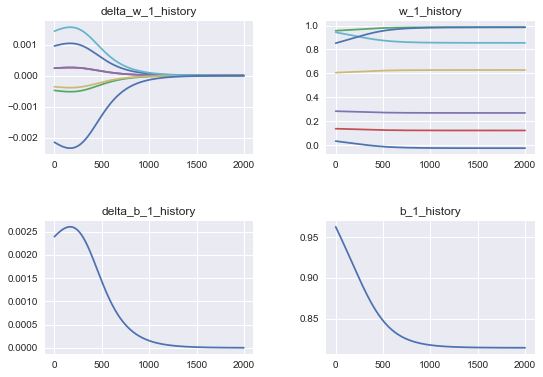

In [9]:
# plot with various axes scales
plt.figure(1)

for j in range(7):
    plt.subplot(221)
    plt.plot(delta_w_1_history[j])
    plt.title("delta_w_1_history")
        
    plt.subplot(222)
    plt.plot(w_1_history[j])
    plt.title("w_1_history")
    
plt.subplot(223)
plt.plot(delta_b_1_history)
plt.title("delta_b_1_history")

plt.subplot(224)
plt.plot(b_1_history)
plt.title("b_1_history")

# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
# https://matplotlib.org/gallery/pyplots/pyplot_scales.html#sphx-glr-gallery-pyplots-pyplot-scales-py
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
plt.show()

w_1의 기울기가 0에 이르는 지점이 bias 학습이 함께 진행될때는 1,200 epoch 정도이나,  
bias 학습을 하지 않으면 1,500 epoch 이상을 넘어선다.

In [10]:
nn.w_1

array([[ 0.15416284,  0.7400497 ,  0.26331502,  0.53373939,  0.01457496,
         0.91874701,  0.90071485],
       [-0.02574465,  0.98653238,  0.1224178 ,  0.26903683,  0.62827046,
         0.85547602,  0.98585922],
       [ 0.00225923,  0.52122603,  0.55203763,  0.48537741,  0.76813415,
         0.16071675,  0.76456045],
       [ 0.0208098 ,  0.13521018,  0.11627302,  0.30989758,  0.67145265,
         0.47122978,  0.8161683 ],
       [ 0.2380425 ,  0.75889812,  0.68973628,  0.3146834 ,  0.35397664,
         0.90074165,  0.74055676],
       [ 0.95018859,  0.76753812,  0.82497802,  0.40660907,  0.45135526,
         0.40044423,  0.99541926]])

In [11]:
# Adam 학습
nn.__init__()

adam_w_1_history = []
adam_b_1_history = []

for _ in range(2000): 
    nn.train(adam)
    
    adam_w_1_history.append(nn.w_1[1][0])
    adam_b_1_history.append(nn.b_1[1][0])

nn.query()
nn.result()

[[-0.]
 [ 0.]]


In [12]:
nn.w_1

array([[ 0.15416284,  0.7400497 ,  0.26331502,  0.53373939,  0.01457496,
         0.91874701,  0.90071485],
       [-0.81311735,  1.80346289, -0.70925378, -0.56263475,  1.45257992,
         0.09767795,  1.69928833],
       [ 0.00225923,  0.52122603,  0.55203763,  0.48537741,  0.76813415,
         0.16071675,  0.76456045],
       [ 0.0208098 ,  0.13521018,  0.11627302,  0.30989758,  0.67145265,
         0.47122978,  0.8161683 ],
       [-0.54559241,  1.5682712 , -0.13245494, -0.50750782,  1.16977011,
         0.14286756,  1.45978018],
       [ 0.3498036 ,  1.36794471,  0.22462189, -0.19374706,  1.05175024,
        -0.19989192,  1.59567079]])

In [13]:
# Momentum 학습
nn.__init__()

momentum_w_1_history = []
momentum_b_1_history = []

for _ in range(2000): 
    nn.train(momentum)
    
    momentum_w_1_history.append(nn.w_1[1][0])
    momentum_b_1_history.append(nn.b_1[1][0])

nn.query()
nn.result()

[[0.]
 [0.]]


In [14]:
nn.w_1

array([[ 0.15416284,  0.7400497 ,  0.26331502,  0.53373939,  0.01457496,
         0.91874701,  0.90071485],
       [-0.02605567,  0.98668788,  0.12234005,  0.26895908,  0.6283871 ,
         0.85500949,  0.98655901],
       [ 0.00225923,  0.52122603,  0.55203763,  0.48537741,  0.76813415,
         0.16071675,  0.76456045],
       [ 0.0208098 ,  0.13521018,  0.11627302,  0.30989758,  0.67145265,
         0.47122978,  0.8161683 ],
       [ 0.23701052,  0.75941411,  0.68947829,  0.31442541,  0.35436363,
         0.89919368,  0.74287871],
       [ 0.94906447,  0.76810018,  0.82469699,  0.40632804,  0.45177681,
         0.39875805,  0.99794853]])

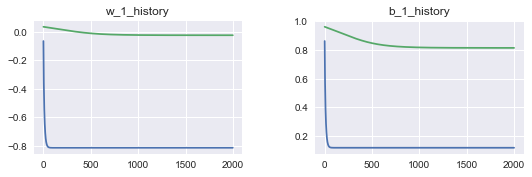

In [15]:
plt.figure(1)

plt.subplot(221)
plt.plot(adam_w_1_history)
plt.plot(w_1_history[0])
plt.title("w_1_history")
        
plt.subplot(222)
plt.plot(adam_b_1_history)
plt.plot(b_1_history)
plt.title("b_1_history")

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
plt.show()

# Adam의 학습 시간은 GD의 1/20 수준에 불과했다. 도달하는 값은 많이 다르다.

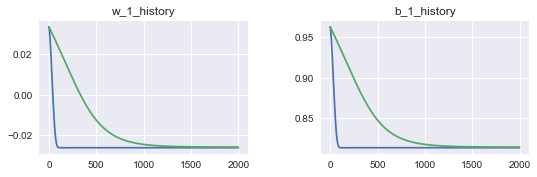

In [16]:
plt.figure(1)

plt.subplot(221)
plt.plot(momentum_w_1_history)
plt.plot(w_1_history[0])
plt.title("w_1_history")
        
plt.subplot(222)
plt.plot(momentum_b_1_history)
plt.plot(b_1_history)
plt.title("b_1_history")

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
plt.show()

# Momentum은 GD와 거의 비슷한 값에 도달하는데, 학습 시간은 1/12 수준에 불과했다.

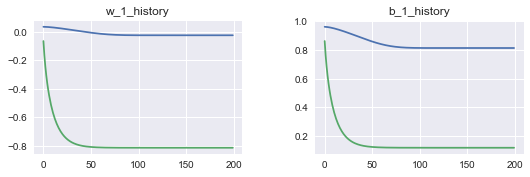

In [17]:
plt.figure(1)

plt.subplot(221)
plt.plot(momentum_w_1_history[:200])
plt.plot(adam_w_1_history[:200])
plt.title("w_1_history")
        
plt.subplot(222)
plt.plot(momentum_b_1_history[:200])
plt.plot(adam_b_1_history[:200])
plt.title("b_1_history")

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
plt.show()

# Adam과 Momentum의 비교, 하락폭이 큰 쪽이 Adam 이다.

In [18]:
# Adam의 m, v 조회
nn.__init__()

adam_m_1_history = []
adam_v_1_history = []
adam_m_1_hat_history = []
adam_v_1_hat_history = []
update_parameters = []

for _ in range(200): 
    nn.train(adam)
    
    adam_m_1_history.append(nn.m[1][0]) # m_k_hat 기준과 동일하게 맞추려면 마지막 레이어인 5로 지정한다.
    adam_v_1_history.append(nn.v[1][0])
    adam_m_1_hat_history.append(nn.m_k_hat[5])
    adam_v_1_hat_history.append(nn.v_k_hat[5])
    update_parameters.append(nn.update_parameters[5])

nn.query()
nn.result()

[[-0.00000018]
 [-0.00000102]]


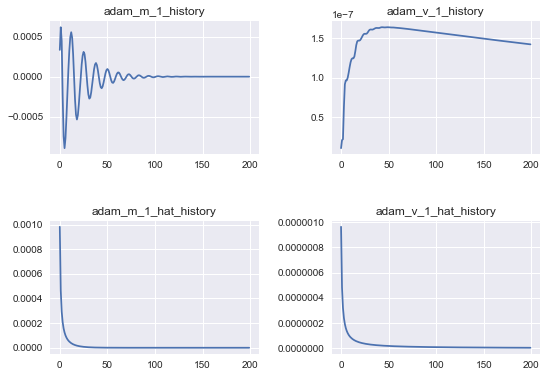

In [19]:
plt.figure(1)

plt.subplot(221)
plt.plot(adam_m_1_history)
plt.title("adam_m_1_history")
        
plt.subplot(222)
plt.plot(adam_v_1_history)
plt.title("adam_v_1_history")

plt.subplot(223)
plt.plot(adam_m_1_hat_history)
plt.title("adam_m_1_hat_history")

plt.subplot(224)
plt.plot(adam_v_1_hat_history)
plt.title("adam_v_1_hat_history")

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
plt.show()

# Adam의 m, v 조회

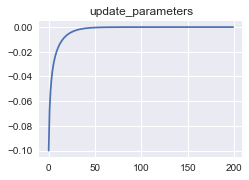

In [20]:
plt.subplot(224)
plt.plot(update_parameters)
plt.title("update_parameters")

plt.show()

# 미분 계산

In [21]:
import sympy
sympy.init_printing(use_latex='mathjax')
w11, x1, w12, x2, w13, x3, b3 = sympy.symbols('w11 x1 w12 x2 w13 x3 b3')
z = w11 * x1 + w12 * x2 + w13 * x3 + b3
z

b₃ + w₁₁⋅x₁ + w₁₂⋅x₂ + w₁₃⋅x₃

In [22]:
sympy.Derivative(z, b3).doit()

1